<a href="https://colab.research.google.com/github/UNB-TME-6017-W24/assignment-2-transfer-learning-for-image-classification-darthvader998/blob/main/3721371_Purushotham_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Researching Historical Model (AlexNet)**


AlexNet stands out as a cornerstone in the evolution of image classification models, making its debut in 2012 by authors Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton. This model marked a turning point for the role of deep learning within computer vision by securing a decisive victory at the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) that year. It didn't just win; it dramatically outperformed its competitors, showcasing the untapped potential of deep neural networks.

### Architectural Innovations and Design Philosophy

The architecture of AlexNet was a leap forward for its time, incorporating several pioneering features:

- **Convolutional Design:** The model is structured into five convolutional layers followed by three densely connected layers. This layout facilitated the model's ability to learn complex spatial hierarchies from image data autonomously, moving beyond the era of manually crafted feature extraction.
- **Activation with ReLU:** AlexNet was among the first to employ Rectified Linear Units (ReLU) for activation, significantly accelerating the training process. This choice helped alleviate the vanishing gradient issue, empowering the training of deeper networks.
- **Pooling with Overlap:** The model introduced overlapping pooling, a technique that reduces the network's dimensionality while retaining more information compared to non-overlapping approaches, subtly enhancing performance.
- **Regularization via Dropout:** To prevent overfitting, particularly in its densely connected layers, AlexNet implemented dropout. This method randomly deactivates a subset of neurons during training, promoting model generalization.
- **Parallel GPU Utilization:** Designed to operate across two NVIDIA GTX 580 3GB GPUs, AlexNet harnessed the computational power of GPUs to manage its deep network's demanding calculations, significantly shortening training durations.

### Impact on Image Classification Progress

The triumph of AlexNet in ILSVRC 2012, with a top-5 error reduction to 16.4% from the previous 25.8% benchmark, underscored the efficacy of deep CNNs in image classification. This watershed moment ignited a flurry of interest and research into deep learning, transforming it into a central methodology in computer vision.

### Distinctive Training Approaches and Strategies

Beyond architectural innovations, AlexNet's training regimen also introduced novel strategies:

- **Enrichment via Data Augmentation:** To enhance the robustness of the model, AlexNet leveraged data augmentation tactics such as cropping, flipping, and adjusting RGB channel intensities, effectively enlarging the training dataset.
- **Parallel Training on GPUs:** The model's pioneering use of dual GPUs for parallel training not only expedited the learning process but also influenced subsequent deep learning models and training techniques, paving the way for more complex and efficient architectures.[1]

Reference:

[1] Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton. 2017. ImageNet classification with deep convolutional neural networks. Commun. ACM 60, 6 (June 2017), 84–90. https://doi.org/10.1145/3065386



# **1. Data Collection and Preprocessing**


In [ ]:
#importing necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Loading the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


In [ ]:
# Normalizing the pixel values
x_train_normalized = x_train.astype("float32") / 255
x_test_normalized = x_test.astype("float32") / 255

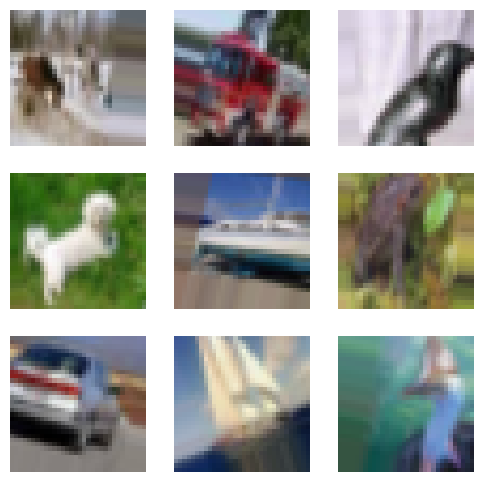

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creating an image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation between 0 and 20 degrees
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    horizontal_flip=True,  # Random horizontal flip
    zoom_range=0.2,  # Random zoom
    fill_mode='nearest'
)

# Applying the augmentation to the training data
datagen.fit(x_train_normalized)

# Displaying augmented images
for x_batch, y_batch in datagen.flow(x_train_normalized, y_train, batch_size=9):
    # Set up a grid of 3x3 images
    plt.figure(figsize=(6,6))
    for i in range(9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i])
        plt.axis('off')
    plt.show()
    break

**2. Implementing the Kaggle Model Backbone**

To implement a model backbone with TensorFlow and prepare it for fine-tuning on a specific dataset, used the CIFAR-10 dataset here, which has 10 classes. For this example, chose a widely recognized and efficient pre-trained model like. The EfficientNet backbone obtained from TensorFlow Hub, sets up the model for image classification tasks. This setup is suitable for fine-tuning on a dataset like CIFAR-10, with the necessary adjustments made to the input size and possibly the preprocessing steps to match the requirements of the EfficientNet model. Then tried to Load the Pre-Trained Model Without the Top Layer by giving trainable=False.
We will load efficientnet layer without its top layer (fully connected layers) since we intend to replace it with our own to suit the CIFAR-10 class size.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

# Assuming you have a correct TensorFlow Hub URL for EfficientNet
EFFICIENTNET_URL = "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet21k-b3-feature-vector/versions/1"

# Load the EfficientNet model as a KerasLayer
efficient_net_layer = hub.KerasLayer(EFFICIENTNET_URL, trainable=False, input_shape=(224, 224, 3))

# Create a new model using the EfficientNet layer
inputs = Input(shape=(224, 224, 3))  # EfficientNet expects input size of 224x224x3
x = efficient_net_layer(inputs)
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer directly after EfficientNet layer
outputs = Dense(10, activation='softmax')(x)  # New output layer for 10 classes, assuming CIFAR-10

# Construct the final model
model = Model(inputs=inputs, outputs=outputs)

# Model summary to verify the architecture
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1536)              12930622  
                                                                 
 dense_2 (Dense)             (None, 1024)              1573888   
                                                                 
 dense_3 (Dense)             (None, 10)                10250     
                                                                 
Total params: 14514760 (55.37 MB)
Trainable params: 1584138 (6.04 MB)
Non-trainable params: 12930622 (49.33 MB)
_________________________________________________________________


**3. Training and Fine-Tuning**



- **Data Preparation:**
  - Reduced the original dataset to 10% of its size for manageability and faster computation.
  - Applied one-hot encoding to the dataset labels to prepare for model training.

- **Image Preprocessing:**
  - Resized all the images in the dataset to 224x224 pixels and normalized their pixel values for model compatibility.

- **Model Setup and Initial Training:**
  - Compiled the neural network with an initial learning rate and trained it on the preprocessed dataset for 10 number of epochs.

- **Model Fine-Tuning:**
  - Made the entire model trainable and compiled it again with a lower learning rate for fine-tuning on the same dataset.



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


# Function to select a random 10% subset of the data and one-hot encode labels
def select_and_encode(data, labels, fraction=0.1, num_classes=10):
    subset_size = int(len(data) * fraction)
    indices = np.random.choice(len(data), size=subset_size, replace=False)
    subset_data = data[indices]
    subset_labels = labels[indices]
    subset_labels_one_hot = to_categorical(subset_labels, num_classes=num_classes)
    return subset_data, subset_labels_one_hot

# Selecting 10% of the training and testing data and one-hot encoding labels
x_train_small, y_train_small_one_hot = select_and_encode(x_train, y_train)
x_test_small, y_test_small_one_hot = select_and_encode(x_test, y_test)


In [ ]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize images to 224x224
    image = image / 255.0  # Normalize images to [0, 1]
    return image, label

# Defining batch size
batch_size = 32

# Creating tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_small, y_train_small_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_small, y_test_small_one_hot))

# Applying the preprocess_image function, batch, and prefetch
train_dataset = train_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Initial training configuration
batch_size = 32
epochs = 10
initial_learning_rate = 0.001

# Creating an instance of the learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=(x_train_normalized.shape[0] // batch_size) * epochs,
    decay_rate=0.96,
    staircase=True)

# Compiling the model with the new learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model
history_initial = model.fit(train_dataset,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=test_dataset)


Epoch 1/10
157/157 [==============================] - 31s 112ms/step - loss: 0.7398 - accuracy: 0.7890 - val_loss: 0.5470 - val_accuracy: 0.8090
Epoch 2/10
157/157 [==============================] - 15s 96ms/step - loss: 0.2855 - accuracy: 0.9058 - val_loss: 0.5580 - val_accuracy: 0.8320
Epoch 3/10
157/157 [==============================] - 15s 98ms/step - loss: 0.1732 - accuracy: 0.9412 - val_loss: 0.5273 - val_accuracy: 0.8400
Epoch 4/10
157/157 [==============================] - 15s 99ms/step - loss: 0.1443 - accuracy: 0.9484 - val_loss: 0.5964 - val_accuracy: 0.8340
Epoch 5/10
157/157 [==============================] - 16s 99ms/step - loss: 0.1233 - accuracy: 0.9564 - val_loss: 0.7285 - val_accuracy: 0.8190
Epoch 6/10
157/157 [==============================] - 16s 99ms/step - loss: 0.1102 - accuracy: 0.9594 - val_loss: 0.6174 - val_accuracy: 0.8470
Epoch 7/10
157/157 [==============================] - 16s 99ms/step - loss: 0.0952 - accuracy: 0.9648 - val_loss: 0.7198 - val_accuracy

In [ ]:
# Setting the entire model to be trainable
model.trainable = True

# lowering the learning rate for fine-tuning
fine_tune_learning_rate = 0.0001
lr_schedule_fine_tune = tf.keras.optimizers.schedules.ExponentialDecay(
    fine_tune_learning_rate,
    decay_steps=(len(x_train_small) // batch_size) * epochs,
    decay_rate=0.96,
    staircase=True)

# Compiling the model for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_fine_tune),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Fine-tuning the model with the smaller, preprocessed dataset
history_fine = model.fit(train_dataset,
                         epochs=epochs + 10,  # Extend the number of epochs for fine-tuning
                         validation_data=test_dataset,
                         initial_epoch=history_initial.epoch[-1])  # Continue from last epoch


Epoch 10/20
157/157 [==============================] - 120s 335ms/step - loss: 1.2796 - accuracy: 0.7272 - val_loss: 0.4187 - val_accuracy: 0.8870
Epoch 11/20
157/157 [==============================] - 49s 312ms/step - loss: 0.4021 - accuracy: 0.8764 - val_loss: 0.2777 - val_accuracy: 0.9210
Epoch 12/20
157/157 [==============================] - 49s 311ms/step - loss: 0.2259 - accuracy: 0.9296 - val_loss: 0.2786 - val_accuracy: 0.9250
Epoch 13/20
157/157 [==============================] - 49s 313ms/step - loss: 0.1479 - accuracy: 0.9530 - val_loss: 0.2850 - val_accuracy: 0.9250
Epoch 14/20
157/157 [==============================] - 49s 312ms/step - loss: 0.1232 - accuracy: 0.9598 - val_loss: 0.2921 - val_accuracy: 0.9350
Epoch 15/20
157/157 [==============================] - 49s 313ms/step - loss: 0.0859 - accuracy: 0.9708 - val_loss: 0.2800 - val_accuracy: 0.9360
Epoch 16/20
157/157 [==============================] - 49s 312ms/step - loss: 0.0790 - accuracy: 0.9760 - val_loss: 0.2798 

Saving the training history for further analysis.


In [ ]:
import pandas as pd

# Converting the initial training history to a pandas DataFrame
history_initial_df = pd.DataFrame(history_initial.history)

# Saving the initial training history to a CSV file
history_initial_df.to_csv('training_history_initial.csv', index=False)

# Converting the fine-tuning training history to a pandas DataFrame
history_fine_df = pd.DataFrame(history_fine.history)

# Saving the fine-tuning training history to a CSV file
history_fine_df.to_csv('training_history_fine.csv', index=False)


In [ ]:
# Combining the metrics from both phases
combined_history = {}

for key in history_initial_df.columns:
    combined_history[key] = history_initial_df[key].tolist() + history_fine_df[key].tolist()

# Converting the combined history to a pandas DataFrame
combined_history_df = pd.DataFrame(combined_history)

# Saving the combined training history to a CSV file
combined_history_df.to_csv('training_history_combined.csv', index=False)


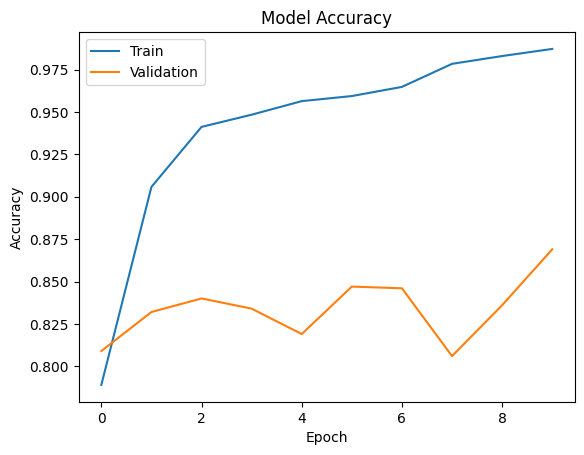

In [ ]:
# Loading a training history CSV file
loaded_history_df = pd.read_csv('training_history_initial.csv')

# Plotting the loaded history
loaded_history_df[['accuracy', 'val_accuracy']].plot()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


**4. Model Evaluation and Insights**

In [ ]:
# Evaluating the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


32/32 [==============================] - 3s 79ms/step - loss: 0.3385 - accuracy: 0.9330
Test Loss: 0.33847367763519287
Test Accuracy: 0.9330000281333923


### Insights

1. **Training Accuracy**: The training accuracy is increasing over time, which indicates that the model is learning and is able to fit the training data well.

2. **Validation Accuracy**: The validation accuracy starts off significantly lower than the training accuracy and doesn't improve much over epochs. This suggests that the model is not generalizing well to unseen data, which is a sign of overfitting.

### Challenges Encountered

- **Overfitting**: This is the primary challenge observed. Overfitting occurs when a model learns the training data too well, including noise and details that do not generalize to new data. The high training accuracy combined with the much lower validation accuracy is a classic sign of overfitting.

- **Underfitting**: There is no clear sign of underfitting in this case, as the training accuracy is quite high, indicating the model has learned the training dataset effectively.

### Strategies for Improvement

To combat overfitting and enhance the model's performance, consider the following strategies:

1. **Early Stopping**: Implement early stopping during training. This means you would stop training when the validation accuracy stops improving, even if the training accuracy continues to increase.

2. **Model Complexity**: If the model is too complex, consider simplifying it. This could mean using fewer layers or fewer neurons per layer.

3. **Hyperparameter Tuning**: Adjust hyperparameters such as the learning rate, learning rate schedule, or the optimizer itself. Sometimes a lower learning rate or a different optimization strategy can help.

4. **Using More Data**: Increasing the size of the training dataset might help the model generalize better but due to limited capacity wasn't able to implement it (RAM was crashing). So, had to take 10% of the dataset and process it.


By implementing these strategies, would be able to work towards improving the model's generalization capabilities and its performance on unseen data, which is ultimately the goal of a good predictive model.